In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings('ignore')

In [2]:
# Data
covtype = fetch_covtype()
X, y = covtype.data, covtype.target

# Exploration
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nClass distribution:")
unique, counts = np.unique(y, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Class {cls}: {cnt:,} ({cnt/len(y)*100:.2f}%)")
print(covtype.feature_names)

X shape: (581012, 54)
y shape: (581012,)

Class distribution:
  Class 1: 211,840 (36.46%)
  Class 2: 283,301 (48.76%)
  Class 3: 35,754 (6.15%)
  Class 4: 2,747 (0.47%)
  Class 5: 9,493 (1.63%)
  Class 6: 17,367 (2.99%)
  Class 7: 20,510 (3.53%)
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soi

In [3]:
# sklearn uses classes 1-7, convert to 0-6 for PyTorch
y = y - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale only the 10 numerical features, leave binary columns (soil/wilderness) as-is
numerical_cols = list(range(10))

scaler = StandardScaler()
X_train[:, numerical_cols] = scaler.fit_transform(X_train[:, numerical_cols])
X_test[:, numerical_cols]  = scaler.transform(X_test[:, numerical_cols])

# Class weights — inverse frequency for 7 classes
total = len(y_train)
weights = []
for cls in range(7):
    cnt = (y_train == cls).sum()
    w = total / (7 * cnt)
    weights.append(w)
    print(f"Class {cls+1}: {cnt:,} samples | weight: {w:.4f}")

class_weights = torch.tensor(weights, dtype=torch.float32)

# Convert to tensors
# y must be torch.long for CrossEntropyLoss
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test,  dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch  = torch.tensor(y_test,  dtype=torch.long)

batch_size = 512

train_ds = TensorDataset(X_train_torch, y_train_torch)
test_ds  = TensorDataset(X_test_torch,  y_test_torch)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

Class 1: 169,472 samples | weight: 0.3918
Class 2: 226,640 samples | weight: 0.2930
Class 3: 28,603 samples | weight: 2.3215
Class 4: 2,198 samples | weight: 30.2099
Class 5: 7,594 samples | weight: 8.7439
Class 6: 13,894 samples | weight: 4.7791
Class 7: 16,408 samples | weight: 4.0469


In [4]:
class CovTypeNet(nn.Module):

    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(64, 7)
            # No softmax — CrossEntropyLoss applies it internally
        )

    def forward(self, x):
        return self.net(x)


inp_dim   = X_train_torch.shape[1]
model     = CovTypeNet(input_dim=inp_dim)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

CovTypeNet(
  (net): Sequential(
    (0): Linear(in_features=54, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=7, bias=True)
  )
)


In [9]:
# Early stopping — equivalent of tf.keras.callbacks.EarlyStopping
class EarlyStopping:

    def __init__(self, patience=10):
        self.patience     = patience
        self.best_loss    = float('inf')
        self.counter      = 0
        self.best_weights = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss    = val_loss
            self.counter      = 0
            self.best_weights = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
        return self.counter >= self.patience

    def restore(self, model):
        model.load_state_dict(self.best_weights)

In [6]:
num_epochs   = 100
train_losses = []
val_losses   = []
es           = EarlyStopping(patience=10)

for epoch in range(num_epochs):

    model.train()
    train_loss_sum = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item() * xb.size(0)

    epoch_train_loss = train_loss_sum / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_loss_sum = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss_sum += loss.item() * xb.size(0)

    epoch_val_loss = val_loss_sum / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1} / {num_epochs} | Train {epoch_train_loss:.4f} | Val {epoch_val_loss:.4f}")

    if es.step(epoch_val_loss, model):
        print(f"\nEarly stopping at epoch {epoch+1} | Best val loss: {es.best_loss:.4f}")
        break

es.restore(model)

Epoch 1 / 100 | Train 0.7974 | Val 0.6012
Epoch 2 / 100 | Train 0.6280 | Val 0.5433
Epoch 3 / 100 | Train 0.5840 | Val 0.5018
Epoch 4 / 100 | Train 0.5519 | Val 0.4769
Epoch 5 / 100 | Train 0.5238 | Val 0.4476
Epoch 6 / 100 | Train 0.5027 | Val 0.4214
Epoch 7 / 100 | Train 0.4832 | Val 0.4085
Epoch 8 / 100 | Train 0.4734 | Val 0.4012
Epoch 9 / 100 | Train 0.4583 | Val 0.3851
Epoch 10 / 100 | Train 0.4477 | Val 0.3714
Epoch 11 / 100 | Train 0.4362 | Val 0.3683
Epoch 12 / 100 | Train 0.4288 | Val 0.3546
Epoch 13 / 100 | Train 0.4221 | Val 0.3506
Epoch 14 / 100 | Train 0.4143 | Val 0.3361
Epoch 15 / 100 | Train 0.4072 | Val 0.3407
Epoch 16 / 100 | Train 0.4044 | Val 0.3348
Epoch 17 / 100 | Train 0.4010 | Val 0.3248
Epoch 18 / 100 | Train 0.3940 | Val 0.3249
Epoch 19 / 100 | Train 0.3962 | Val 0.3223
Epoch 20 / 100 | Train 0.3874 | Val 0.3103
Epoch 21 / 100 | Train 0.3853 | Val 0.3111
Epoch 22 / 100 | Train 0.3855 | Val 0.3129
Epoch 23 / 100 | Train 0.3789 | Val 0.3128
Epoch 24 / 100 | Tra

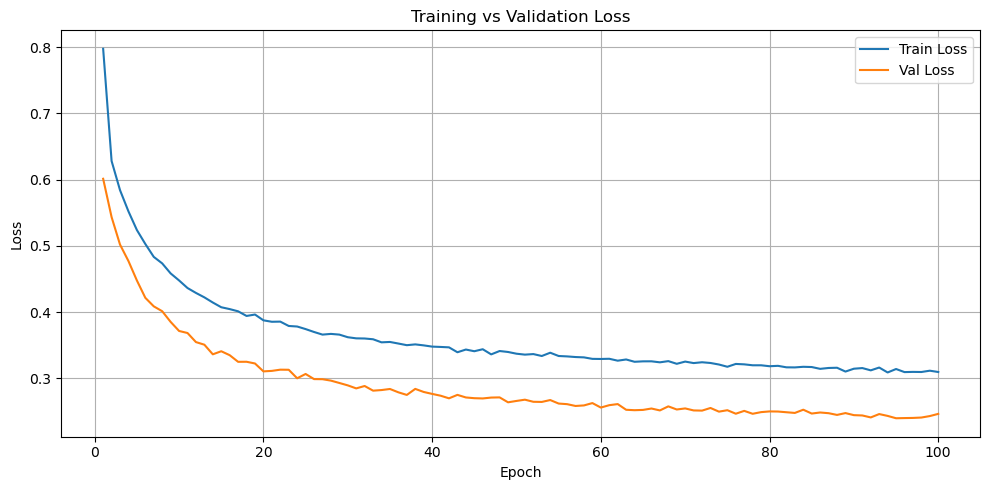

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
ax.plot(range(1, len(val_losses)   + 1), val_losses,   label='Val Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

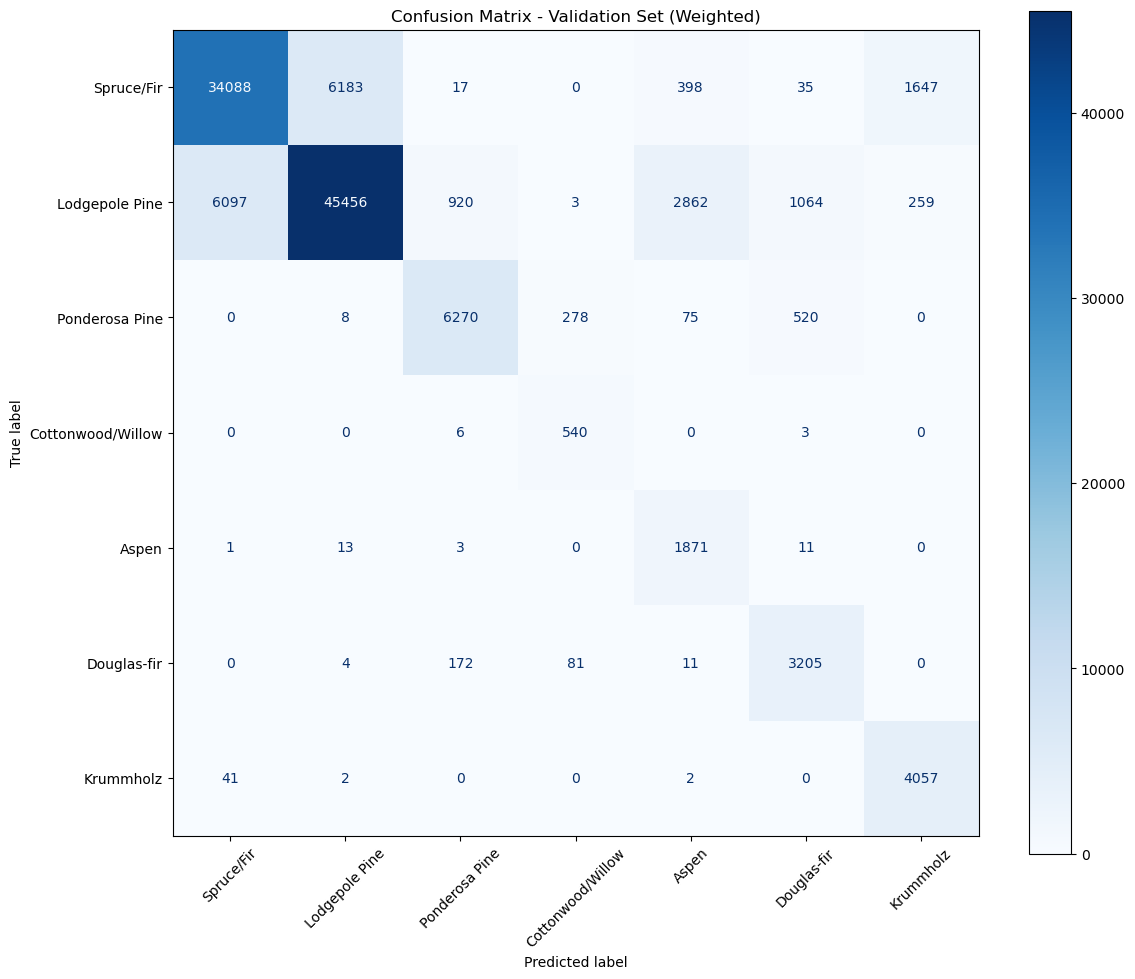

                   precision    recall  f1-score   support

       Spruce/Fir       0.85      0.80      0.83     42368
   Lodgepole Pine       0.88      0.80      0.84     56661
   Ponderosa Pine       0.85      0.88      0.86      7151
Cottonwood/Willow       0.60      0.98      0.74       549
            Aspen       0.36      0.99      0.53      1899
      Douglas-fir       0.66      0.92      0.77      3473
        Krummholz       0.68      0.99      0.81      4102

         accuracy                           0.82    116203
        macro avg       0.70      0.91      0.77    116203
     weighted avg       0.84      0.82      0.83    116203



In [8]:
labels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine',
          'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

model.eval()
with torch.no_grad():
    y_pred = torch.argmax(model(X_test_torch), dim=1).numpy()

y_true = y_test_torch.numpy()

cm   = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title('Confusion Matrix - Validation Set (Weighted)')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))

In [11]:
num_epochs   = 1
train_losses_ = []
val_losses_   = []
es           = EarlyStopping(patience=10)

for epoch in range(num_epochs):

    model.train()
    train_loss_sum = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()

        for name, param in model.named_parameters():
            print(f"{name:30s} | grad norm: {param.grad.norm().item():.6f}")

        optimizer.step()
        train_loss_sum += loss.item() * xb.size(0)

    epoch_train_loss = train_loss_sum / len(train_loader.dataset)
    train_losses_.append(epoch_train_loss)

    model.eval()
    val_loss_sum = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss_sum += loss.item() * xb.size(0)

    epoch_val_loss = val_loss_sum / len(val_loader.dataset)
    val_losses_.append(epoch_val_loss)

    print(f"Epoch {epoch+1} / {num_epochs} | Train {epoch_train_loss:.4f} | Val {epoch_val_loss:.4f}")

    if es.step(epoch_val_loss, model):
        print(f"\nEarly stopping at epoch {epoch+1} | Best val loss: {es.best_loss:.4f}")
        break

es.restore(model)

net.0.weight                   | grad norm: 1.318911
net.0.bias                     | grad norm: 0.287775
net.3.weight                   | grad norm: 0.187767
net.3.bias                     | grad norm: 0.100535
net.6.weight                   | grad norm: 0.114432
net.6.bias                     | grad norm: 0.045627
net.9.weight                   | grad norm: 0.437877
net.9.bias                     | grad norm: 0.024226
net.0.weight                   | grad norm: 0.821344
net.0.bias                     | grad norm: 0.170339
net.3.weight                   | grad norm: 0.110765
net.3.bias                     | grad norm: 0.061589
net.6.weight                   | grad norm: 0.068174
net.6.bias                     | grad norm: 0.022857
net.9.weight                   | grad norm: 0.236249
net.9.bias                     | grad norm: 0.016813
net.0.weight                   | grad norm: 0.805592
net.0.bias                     | grad norm: 0.190983
net.3.weight                   | grad norm: 0.

In [17]:
#How to extract more information about the training process

num_epochs    = 10
train_losses_ = []
val_losses_   = []
es            = EarlyStopping(patience=10)

for epoch in range(num_epochs):

    # Training 
    model.train()
    train_loss_sum = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item() * xb.size(0)

    epoch_train_loss = train_loss_sum / len(train_loader.dataset)
    train_losses_.append(epoch_train_loss)

    # Gradient norms (once per epoch, not per batch) 
    for name, param in model.named_parameters():
        print(f"{name:30s} | grad norm: {param.grad.norm().item():.6f}")

    # Validation 
    model.eval()
    val_loss_sum   = 0
    all_confidence = []
    all_predicted  = []
    all_labels     = []

    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss_sum += loss.item() * xb.size(0)

            probs = torch.softmax(pred, dim=1)
            conf, preds = probs.max(dim=1)

            all_confidence.append(conf)
            all_predicted.append(preds)
            all_labels.append(yb)

    all_confidence = torch.cat(all_confidence)
    all_predicted  = torch.cat(all_predicted)
    all_labels     = torch.cat(all_labels)

    epoch_val_loss = val_loss_sum / len(val_loader.dataset)
    val_losses_.append(epoch_val_loss)

    # Least confident predictions 
    least_confident = all_confidence.argsort()[:5]
    print("Most uncertain predictions:")
    for idx in least_confident:
        print(f"  True: {all_labels[idx].item()} | Pred: {all_predicted[idx].item()} | Confidence: {all_confidence[idx].item():.3f}")

    print(f"Epoch {epoch+1} / {num_epochs} | Train {epoch_train_loss:.4f} | Val {epoch_val_loss:.4f}")

    # Early stopping 
    if es.step(epoch_val_loss, model):
        print(f"\nEarly stopping at epoch {epoch+1} | Best val loss: {es.best_loss:.4f}")
        break

es.restore(model)

net.0.weight                   | grad norm: 0.501908
net.0.bias                     | grad norm: 0.127431
net.3.weight                   | grad norm: 0.155982
net.3.bias                     | grad norm: 0.062646
net.6.weight                   | grad norm: 0.073704
net.6.bias                     | grad norm: 0.022141
net.9.weight                   | grad norm: 0.337536
net.9.bias                     | grad norm: 0.011782
Most uncertain predictions:
  True: 1 | Pred: 5 | Confidence: 0.275
  True: 0 | Pred: 2 | Confidence: 0.280
  True: 1 | Pred: 4 | Confidence: 0.285
  True: 1 | Pred: 1 | Confidence: 0.287
  True: 0 | Pred: 1 | Confidence: 0.291
Epoch 1 / 10 | Train 0.3070 | Val 0.2431
net.0.weight                   | grad norm: 1.043762
net.0.bias                     | grad norm: 0.268916
net.3.weight                   | grad norm: 0.310923
net.3.bias                     | grad norm: 0.105243
net.6.weight                   | grad norm: 0.160573
net.6.bias                     | grad norm